
О чем проект:

Аналитика развлекательного приложения. 
Предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.



In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

costs =  pd.read_csv('/datasets/costs_info_short.csv')# информацию о расходах на рекламу
orders = pd.read_csv('/datasets/orders_info_short.csv')#информацию о покупках
visits = pd.read_csv('/datasets/visits_info_short.csv')#хранит лог сервера с информацией о посещениях сайта
                      

In [2]:
costs = costs.rename(columns  = {'Channel':'channel'})
orders = orders.rename(columns  = {'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'})
visits = visits.rename(columns = {'Channel':'channel','User Id':'user_id','Region':'region','Device':'device',
                                                           'Session Start':'session_start',
                                                           'Session End':'session_end'})

In [3]:
#Приведем к нижнему регистру

costs['channel'] = costs['channel'].str.lower()
visits['region'] = visits['region'].str.lower()
visits['device'] = visits['device'].str.lower()
visits['channel']= visits['channel'].str.lower()

In [9]:
costs.info()
costs.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1


In [10]:
orders.info()
orders.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null object
revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [12]:
visits.info()
visits.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null object
session_end      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,user_id,region,device,channel,session_start,session_end
0,981449118918,united states,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,united states,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,united states,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,united states,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,united states,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [13]:
#проверили на наличие дубликатов. Их нет
costs,orders,visits.isna().sum()

(              dt         channel  costs
 0     2019-05-01        faceboom  113.3
 1     2019-05-02        faceboom   78.1
 2     2019-05-03        faceboom   85.8
 3     2019-05-04        faceboom  136.4
 4     2019-05-05        faceboom  122.1
 ...          ...             ...    ...
 1795  2019-10-23  lambdamediaads    4.0
 1796  2019-10-24  lambdamediaads    6.4
 1797  2019-10-25  lambdamediaads    8.8
 1798  2019-10-26  lambdamediaads    8.8
 1799  2019-10-27  lambdamediaads   12.0
 
 [1800 rows x 3 columns],
             user_id             event_dt  revenue
 0      188246423999  2019-05-01 23:09:52     4.99
 1      174361394180  2019-05-01 12:24:04     4.99
 2      529610067795  2019-05-01 11:34:04     4.99
 3      319939546352  2019-05-01 15:34:40     4.99
 4      366000285810  2019-05-01 13:59:51     4.99
 ...             ...                  ...      ...
 40207  651604369137  2019-10-31 16:19:07     4.99
 40208  275341387049  2019-10-31 01:17:17     4.99
 40209  374656616484 

In [14]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 



Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии

In [15]:
# функция для создания пользовательских профилей
 
def get_profiles(sessions, orders, ad_costs):
 
    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
 
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
 
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
 
 
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
 
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
 
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
 
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
 
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
 
    return profiles

### Функция для расчёта удержания

In [21]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта конверсии

In [22]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта LTV и ROI

In [82]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)
        
        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes
        

        

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Шаг 3. Проведите исследовательский анализ данных

In [24]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.230769


In [27]:
#Установим момент и горизонт анализа данных и зададим недельный горизонт анализа.Дату возьмем из условия задачи.
observation_date = datetime(2019, 5, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [28]:
#Определим минимальную и максимальную даты привлечения пользователей.
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()  

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.


In [29]:
by_region = profiles.groupby('region').agg({'user_id': 'nunique', 'payer':'sum'},dropna=True)
by_region['%'] = (by_region['payer']/by_region['user_id'])
by_region.columns = ['Пользователи', 'Платящие пользователи','% платящих']
by_region = by_region.sort_values(by =['Пользователи'],ascending = False)
by_region.style.format({'% платящих':'{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
region,,,
united states,100002,6902,6.90%
uk,17575,700,3.98%
france,17450,663,3.80%
germany,14981,616,4.11%


Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [30]:
by_device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer':'sum'},dropna=True)
by_device['%'] = (by_device['payer']/by_device['user_id'])
by_device.columns = ['Пользователи', 'Платящие пользователи','% платящих']
by_device = by_device.sort_values(by =['Пользователи'],ascending = False)
by_device.style.format({'% платящих':'{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
device,,,
iphone,54479,3382,6.21%
android,35032,2050,5.85%
pc,30455,1537,5.05%
mac,30042,1912,6.36%


Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [31]:
by_channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':'sum'},dropna=True)
by_channel['%'] = (by_channel['payer']/by_channel['user_id'])
by_channel.columns = ['Пользователи', 'Платящие пользователи','% платящих']
by_channel = by_channel.sort_values(by =['Пользователи'],ascending = False)
by_channel.style.format({'% платящих':'{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
channel,,,
organic,56439,1160,2.06%
faceboom,29144,3557,12.20%
tiptop,19561,1878,9.60%
opplecreativemedia,8605,233,2.71%
leapbob,8553,262,3.06%
wahoonetbanner,8553,453,5.30%
rocketsuperads,4448,352,7.91%
mediatornado,4364,156,3.57%
yrabbit,4312,165,3.83%


Шаг 4. Маркетинг
4.1. Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени.


In [87]:
#уберем органиков из исследования тк их данные могут исказить результат
profiles = profiles.query('channel != "organic"')

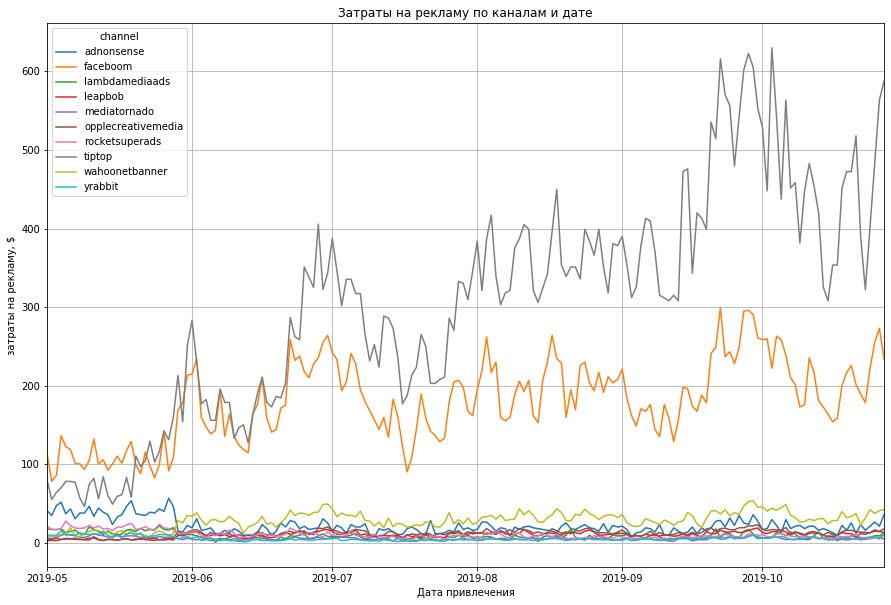

In [88]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('затраты на рекламу, $')
plt.xlabel('Дата привлечения')
plt.title('Затраты на рекламу по каналам и дате')
plt.show()






Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Используем профили пользователей.


In [89]:
profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by =['acquisition_cost'],ascending = False)

,acquisition_cost
channel,
tiptop,2.799003
faceboom,1.113286
adnonsense,1.008054
lambdamediaads,0.724802
wahoonetbanner,0.602245
rocketsuperads,0.412095
opplecreativemedia,0.250000
yrabbit,0.218975
mediatornado,0.218717


Промежуточные выводы :Стоимость привлечения «органических» пользователей во всех когортах равна нулю, потому что они перешли самостоятельно, а не благодаря рекламе. Привлечение одного пользователя  обошлось компании в среднем  от 21 цента до 2,7 долларов.

Шаг 5. Оценим окупаемость рекламы
Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.


In [91]:
# функция для визуализации LTV и ROI
 
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
 
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))
 
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
 
    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']] 
    

 
    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    
             
    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
 
    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
 
    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
 
    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
 
    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
 
    plt.tight_layout()
    plt.show() 
 


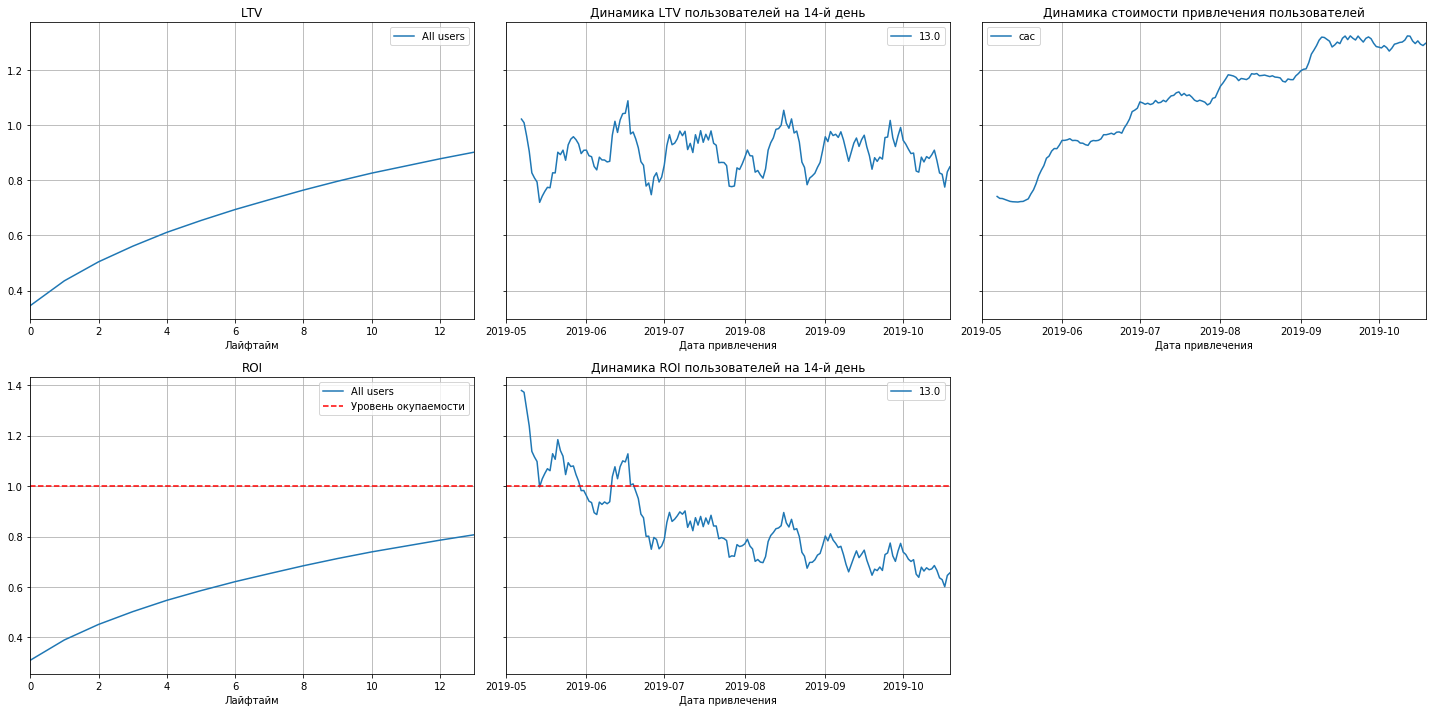

In [92]:
 
# функция для сглаживания фрейма
 
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# задаем момент и горизонт анализа

observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
 
# считаем  LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
 
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Вот что говорят графики:
Реклама не окупается везде.
Стоимость привлечения стабильна растет.
LTV растет.



Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 

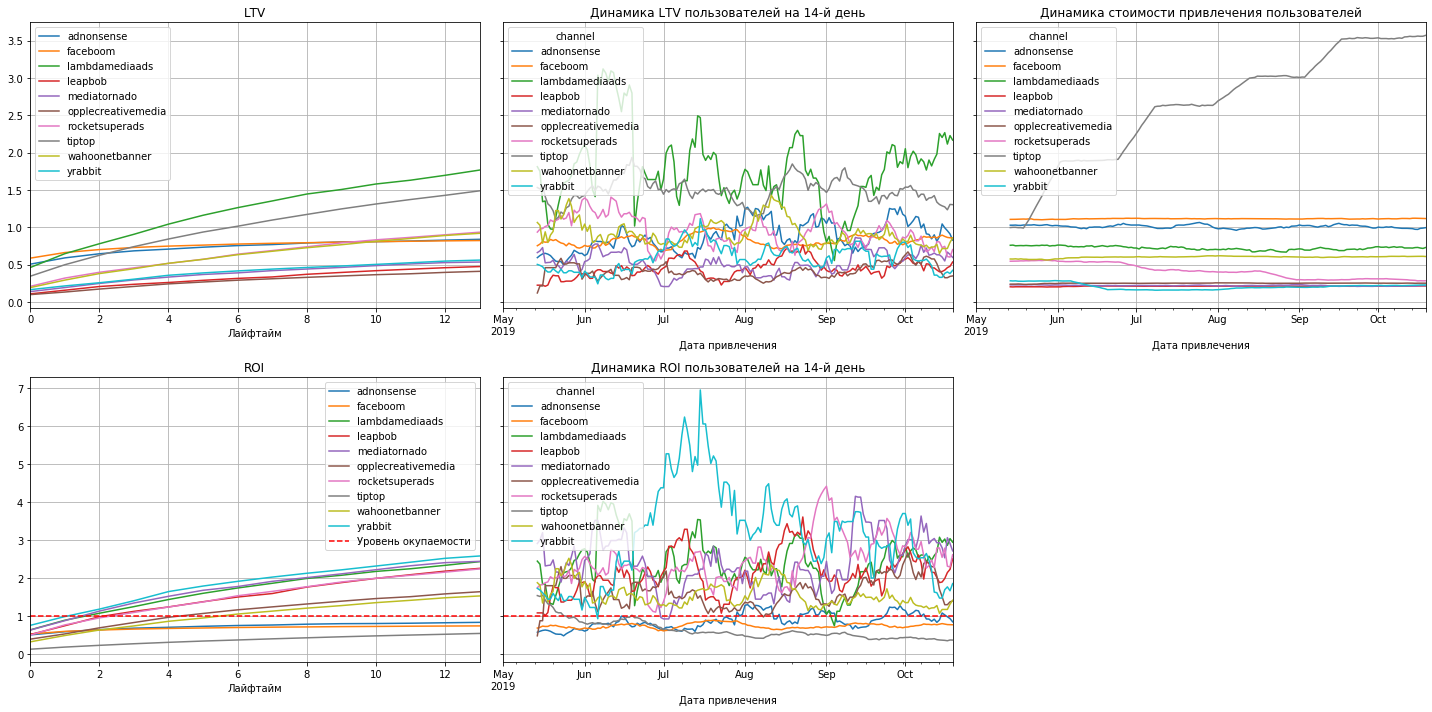

In [96]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']


ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Реклама не окупается везде.
Стоимость привлечения стабильна и одинакова для всех стран.
LTV растет
По всем графикам выделяется канал  'adnonsense', на него тратится больше средств но он приносит пользователей.

 Проанализируйем окупаемость рекламы с разбивкой по странам

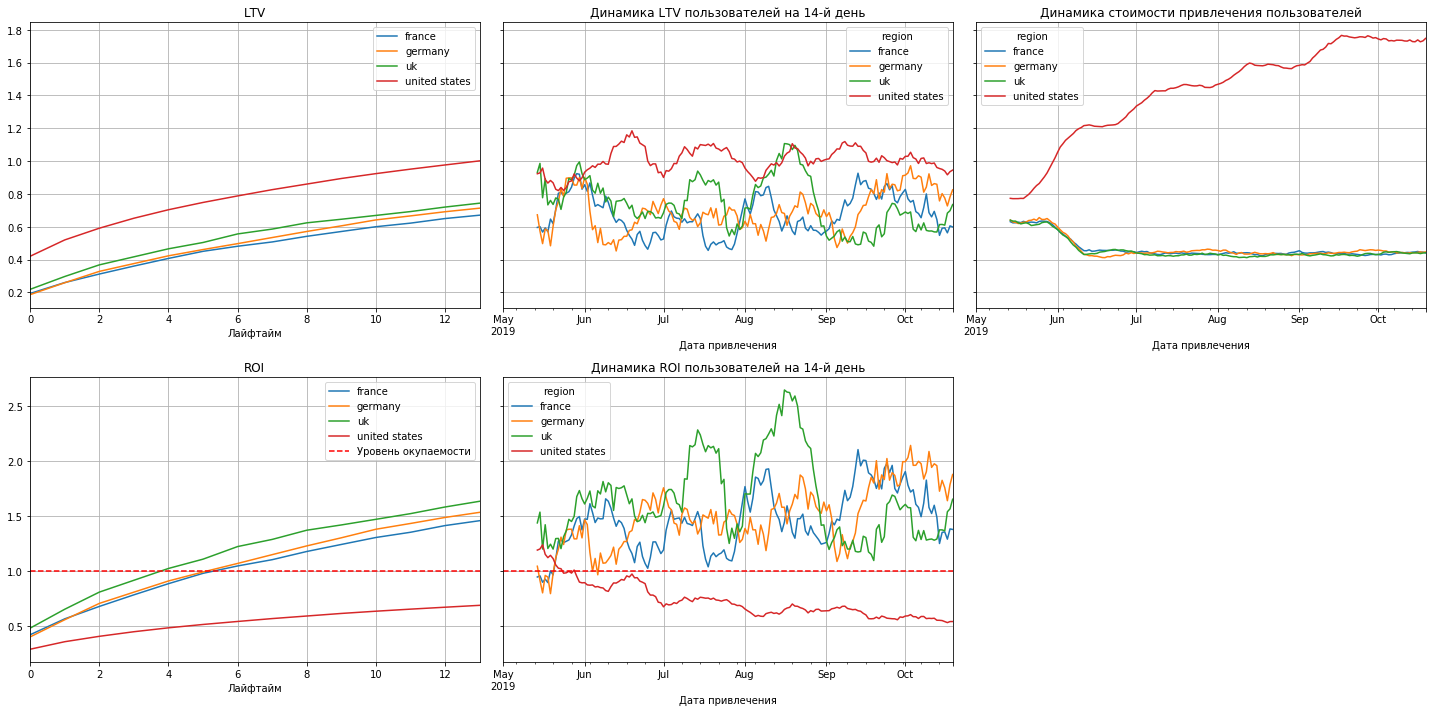

In [97]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)


Реклама не окупается везде.
Стоимость привлечения стабильна и одинакова для всех стран, кроме  usa.
LTV всё так же подвержен сезонности, но стабилен.
По всем графикам проседает USA

Построим  и изучиим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

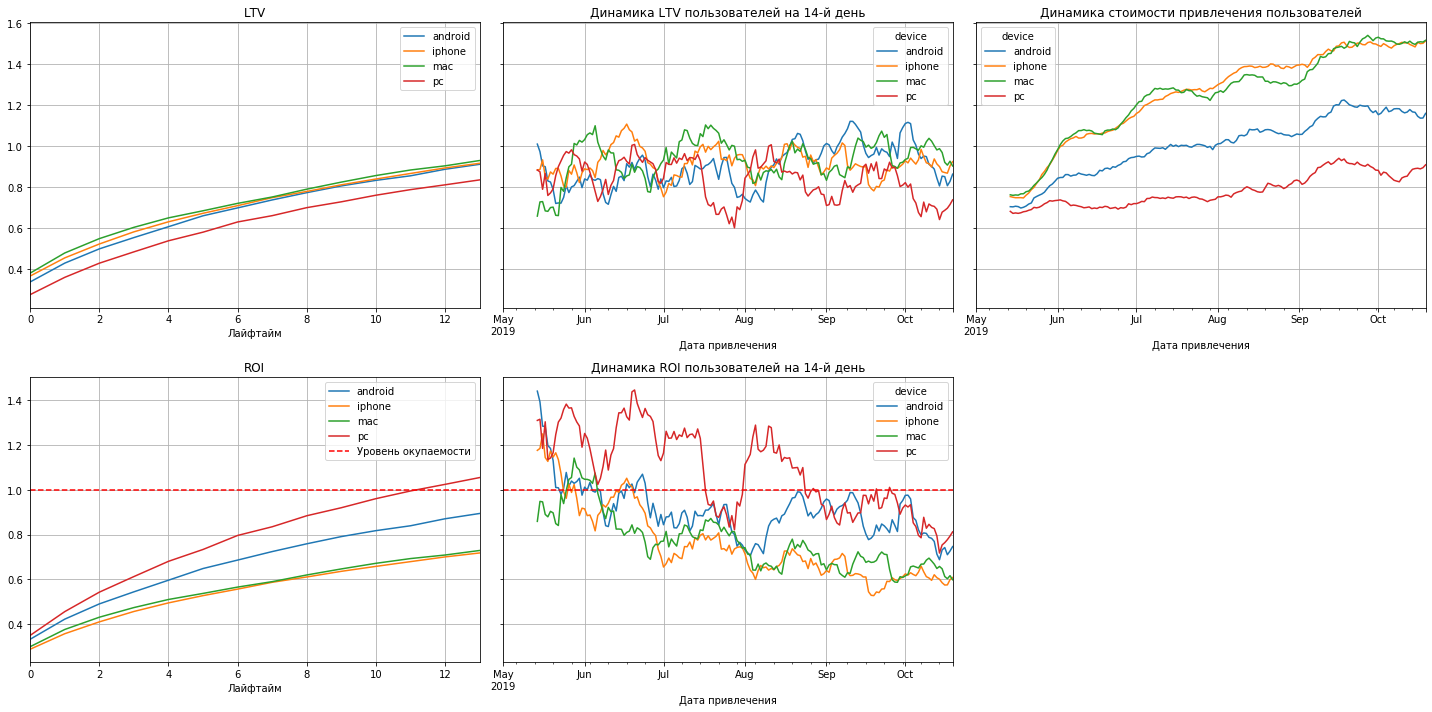

In [98]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Окупаются владельцы  PC и немного  android, владельцы apple, mac не окупаются

In [99]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

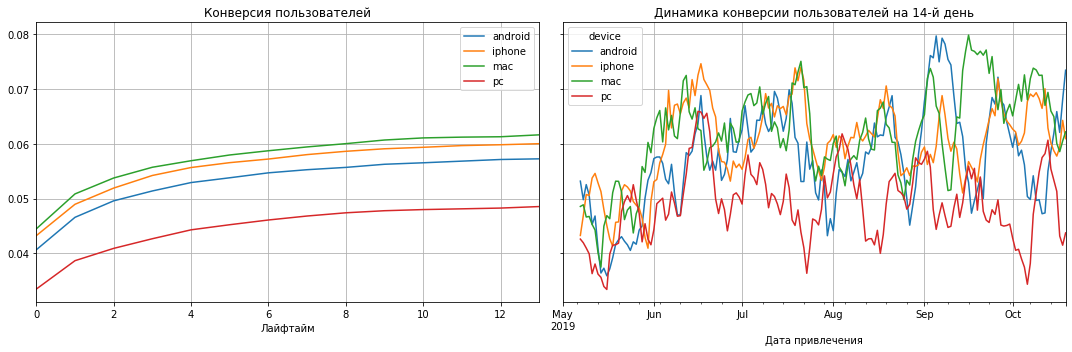

In [40]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [100]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

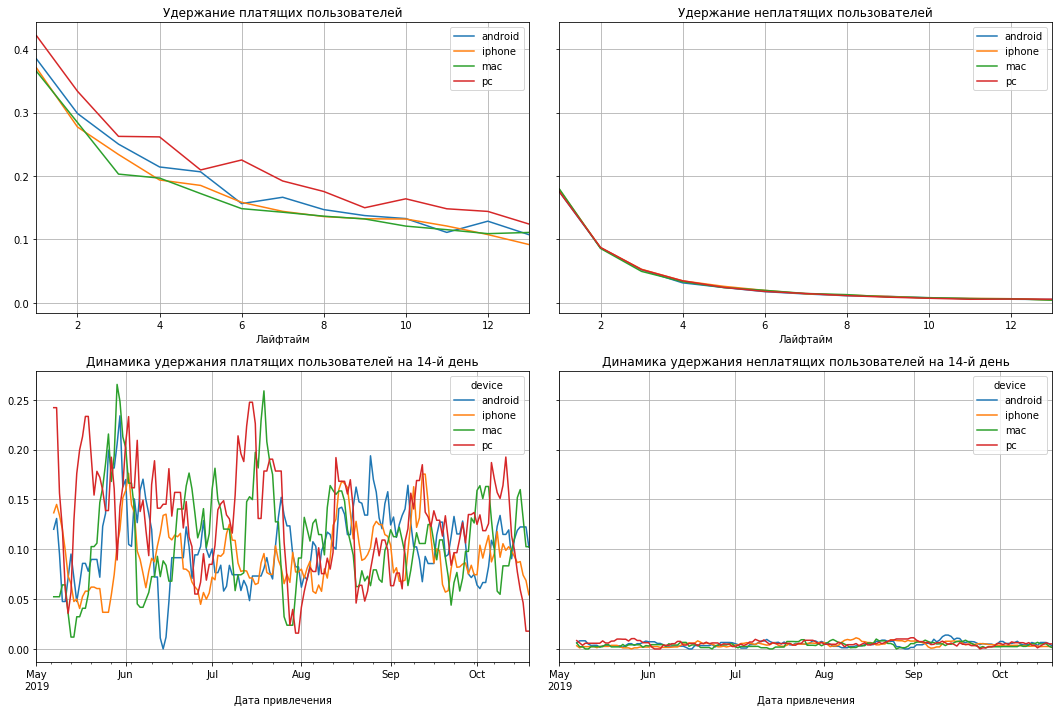

In [101]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)



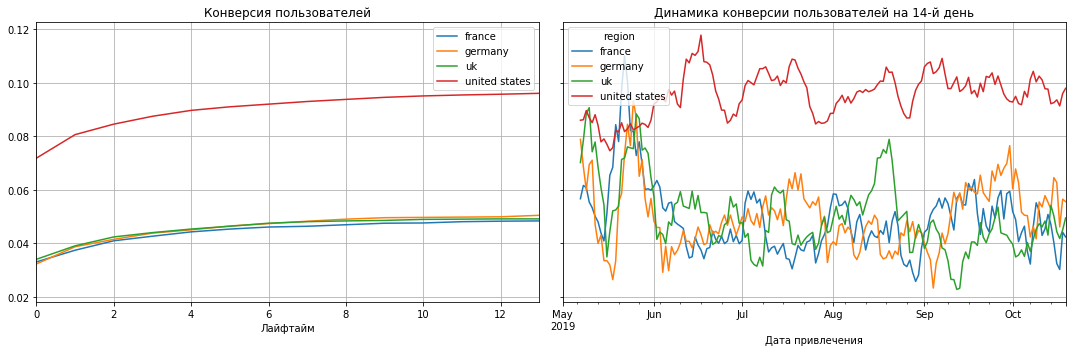

In [102]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

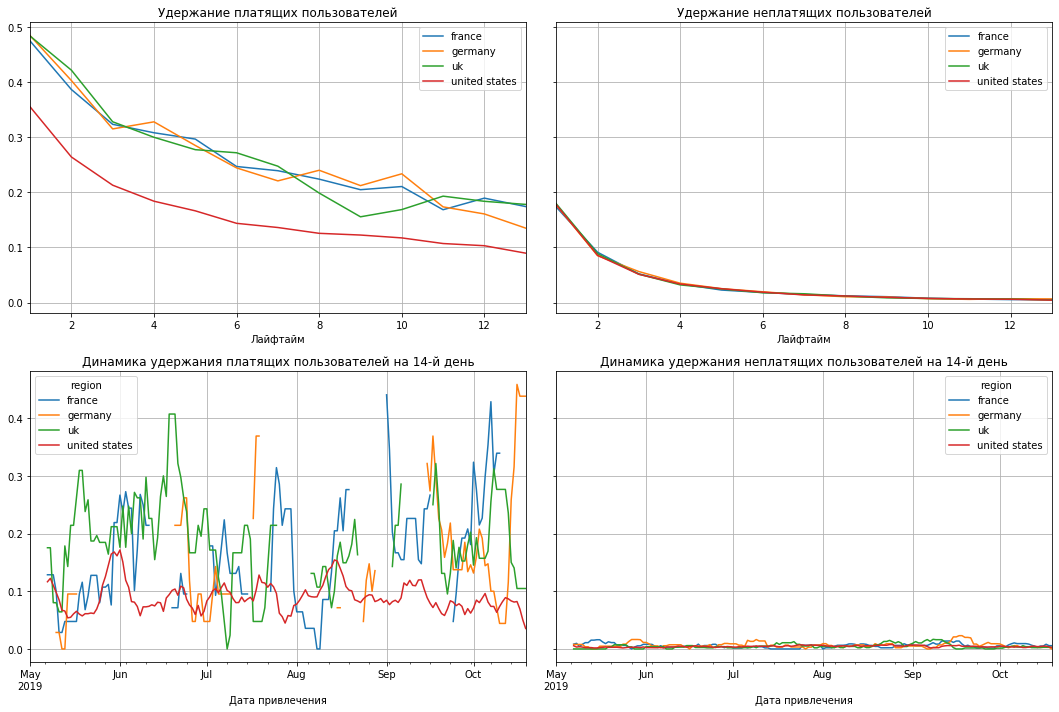

In [103]:
# смотрим удержание с разбивкой по странам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

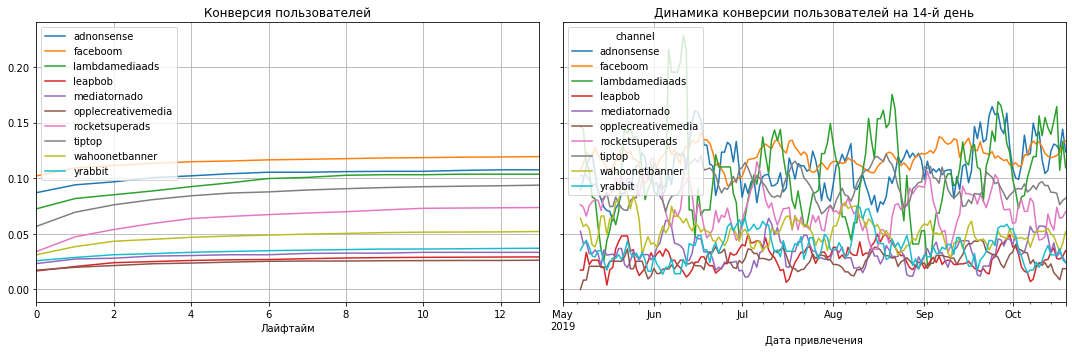

In [104]:
# смотрим конверсию с разбивкой по каналам


dimensions = ['channel'] 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

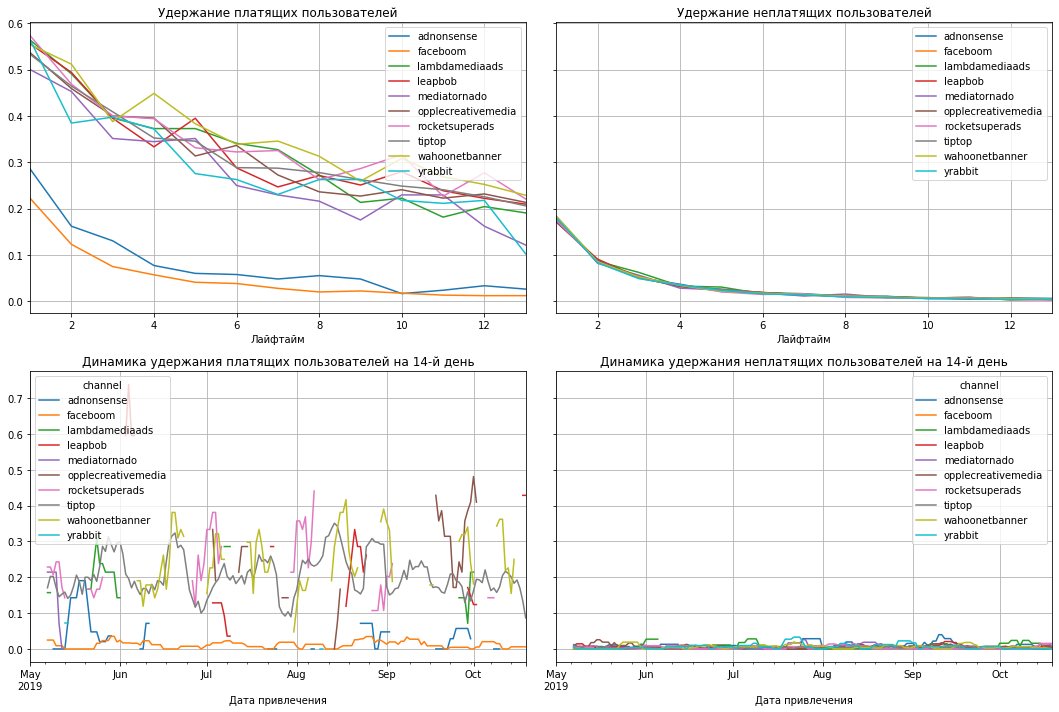

In [105]:
# смотрим удержание с разбивкой по рекламным каналам

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)


1.Реклама в целом окупается, есть проблемы локальные в США и с платформами  apple и mac.

2.Окупаемость снижают устройства  apple и mac, в основном в США, facedoom и  yrabbit из каналов.
Чем могут быть вызваны проблемы окупаемости?
Возможно причина в какой-нибудь технической проблеме или сезоне.


Вывод:Нужно проверить все ли данные собраны верно и нет ли технической проблемы.
Рекомендациия для отдела маркетинга: уделить особое внимение региону сша, возможно изменить маркетинговый план.Сократить количество каналов